In [1]:
import pandas as pd
import numpy as np
import random
from pandas.api.types import CategoricalDtype

### Overall Logic

![ElectricalModel_frame](ElectricalModel_frame.png)

In [2]:
def excludingfromMNY(df,pct_escooter_N,pct_bicycle_N):
    '''
    [Input]
    df: the input dataframe should be the output df of the commuter model, for now, operations such as adding new columns (MNY_RES) are performed outside/before
    pct_escooter_N: % of Escooter no need to charge in MNY, we can interpret this number as (MNY_RES not EV + non_MNY_RES prefer charge at home)
    pct_bicycle_N: % of E-Bicycle no need to charge in MNY, we can interpret this number as (MNY_RES not EV + non_MNY_RES prefer charge at home)
    ### future: taxi narrow to MNY
    
    [Output]
    series (0,1) indicating whether each line should be exclude from the electric model or not
    excluding: True/1; keep: False/0
    '''
    
    autos_motorcycle_hardcap = (df['HOMEOWNER_LABEL']=='Own') & (df['MNY_RES']==0) & (df['TransMode'].isin(['AutoOccupants','Motorcycle']))
    bus_hardcap = (df['MNY_RES']==0) & (df['TransMode'].isin(['Bus']))

    escooter_flag = df['TransMode'].apply(lambda x: True if random.random() <= pct_escooter_N/100 and x=='Escooter' else False)
    bicycle_flag = df['TransMode'].apply(lambda x: True if random.random() <= pct_bicycle_N/100 and x=='Bicycle' else False)
    
    final_series = autos_motorcycle_hardcap | bus_hardcap | escooter_flag | bicycle_flag
    
    return final_series.astype(int)

In [3]:
def NumberOfEV(row):
    ### For each row, getting the number of EVs
    if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle','Taxicab']:
        return row['PERWT']
    elif row['TransMode']=='Bus':
        return row['PERWT']/20
    elif row['TransMode']=='Ferry':
        return row['PERWT']/100
    elif row['TransMode'] in ['Subway','CommuterRail']:
        return 1 

    
def TotalEnergyPerEV(row):
    ### For each row, getting the total energy for EACH EV
    if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle']:
        return row['DISTANCE_KM']*row['Multiplier']*2
    elif row['TransMode'] in ['Bus','Taxicab']:
        return row['DISTANCE_KM']*row['Multiplier']
    elif row['TransMode']=='Ferry':
        return row['Multiplier']
    elif row['TransMode'] in ['Subway','CommuterRail']:
        return row['PERWT']*row['Multiplier']

    
def HourEnergyPerEV(row, PEV_delay_hr=3):
    '''
    For each row, getting the hourly energy for EACH EV
    [Input]
    rows of dataframe?
    PEV_delay_hr: customized delayed hour for personal EV
    [Output]
    rows with 5 new columns (type: list): Energy & Charge_Hour_ER / Charge_Hour_LT / Charge_Hour_RND / Charge_Hour_CM
    Energy: regardless of delay type, energy list will always be the same
    Charge_Hour_ER: The earliest charging, i.e., right start when arrived at work
    Charge_Hour_LT: The latest charging, but can also charge for enough energy
    Charge_Hour_RND: random delay, 0-max_delay (including)
    Charge_Hour_CM: customized delay, min(input, max_delay)
    '''
     
    if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle','Taxicab','Bus','Ferry']:
        hour = list(range(0,24))*2
        atwork_hour_list = hour[row['HOUR'] : row['HOUR']+row['HRS_WK_DAILY']]
        charging_hr_roundup = np.ceil(row['TotalEnergyPerEV']/row['ChargingPower_kW'])
        duration_hr = int(min(charging_hr_roundup,row['HoursToFullyRecharge_hr'],row['HRS_WK_DAILY']))
        energy = int(row['TotalEnergyPerEV']//row['ChargingPower_kW'])*[row['ChargingPower_kW']] + [row['TotalEnergyPerEV']%row['ChargingPower_kW']]
        energy_list = energy[:duration_hr]
    
        if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle']:
            
            max_delay = row['HRS_WK_DAILY'] - duration_hr
            random_delay = random.randint(0,max_delay)
            PEV_delay_hr = int(min(PEV_delay_hr, max_delay))
            row['Charge_Hour_ER'] = atwork_hour_list[:duration_hr]
            row['Charge_Hour_LT'] = atwork_hour_list[-duration_hr:]
            row['Charge_Hour_RND'] = atwork_hour_list[random_delay:duration_hr+random_delay]
            row['Charge_Hour_CM'] = atwork_hour_list[PEV_delay_hr:duration_hr+PEV_delay_hr]     
            row['Energy'] = energy_list
            return row 
        elif row['TransMode'] in ['Bus','Ferry','Taxicab']:
            delay = 6
            hour_list = hour[row['HOUR']+delay : row['HOUR']+delay+duration_hr]
            row['Charge_Hour_ER'] = hour_list
            row['Charge_Hour_LT'] = hour_list
            row['Charge_Hour_RND'] = hour_list
            row['Charge_Hour_CM'] = hour_list
            row['Energy'] = energy_list
            return row 
        
    elif row['TransMode'] in ['Subway','CommuterRail']:
        hour_list = [row['HOUR']]
        row['Charge_Hour_ER'] = hour_list
        row['Charge_Hour_LT'] = hour_list
        row['Charge_Hour_RND'] = hour_list
        row['Charge_Hour_CM'] = hour_list
        row['Energy'] = [row['TotalEnergyPerEV']]
        return row 
    
def floor(row):
    ### For agg energy at hour-mode-dir level, adding floor energy for specific modes
    if row['TransMode']=='Subway':
        return row['Energy']+subway_floor
    elif row['TransMode']=='CommuterRail':
        return row['Energy']+commuterRail_floor 
    else:
        return row['Energy']

In [4]:
def HourEnergy(df):
    '''
    [Input] df: the inbound or outbound flow dataframe
    [Output] A dataframe shows the agg energy at hour-mode-dir-delaytype level, data structures: Charge_Hour, FLOW_DIR, PEV_DELAY, TransMode, Energy
    This function wraps up the above four functions: NumberOfEV, TotalEnergyPerEV, HourEnergyPerEV, floor
    '''
    
    df = df.merge(right=EV_reference_table[['TransMode','Multiplier','ChargingPower_kW','HoursToFullyRecharge_hr']], on=["TransMode"], how='inner')
    df['NumberOfEV'] = df.apply(lambda row: NumberOfEV(row), axis=1)
    df['TotalEnergyPerEV'] = df.apply(lambda row: TotalEnergyPerEV(row), axis=1)
    df = df.apply(HourEnergyPerEV, axis=1) ### this step is a little slow
    df = df.explode(['Charge_Hour_ER','Charge_Hour_LT','Charge_Hour_RND','Charge_Hour_CM','Energy'])
    df['Energy'] = df['Energy']*df['NumberOfEV'] ### energy per EV --> energy all EV
    
    value_vars = [c for c in df if c.startswith('Charge_Hour_')]
    df_melt = pd.melt(df, id_vars=["TransMode","FLOW_DIR","Energy"], value_vars=value_vars, var_name='PEV_DELAY', value_name='Charge_Hour')
    df_agg = df_melt.groupby(by=["Charge_Hour","TransMode","PEV_DELAY","FLOW_DIR"]).agg({"Energy":"sum"}).reset_index()
    
    delay_dict = {'Charge_Hour_ER':'Earliest',
                  'Charge_Hour_LT':'Latest',
                  'Charge_Hour_RND':'Random',
                  'Charge_Hour_CM':'Custom'}
    df_agg["PEV_DELAY"] = df_agg["PEV_DELAY"].replace(delay_dict)

    df_agg['Energy'] = df_agg.apply(lambda row: floor(row), axis=1)
    
    return df_agg

### HOW TO RUN

In [5]:
EV_reference_table = pd.read_csv("EV_reference_table.csv")
subway_floor = int(EV_reference_table[EV_reference_table['TransMode']=='Subway']['Floor_kWh'])
commuterRail_floor = int(EV_reference_table[EV_reference_table['TransMode']=='CommuterRail']['Floor_kWh'])
EV_reference_table

,TransMode,ChargingPower_kW,HoursToFullyRecharge_hr,Floor_kWh,Multiplier,MultiplierUnit,excludingfromMNY,NumberOfEV,TotalEnergyPerEV,HourEnergyPerEV,Energy
0,AutoOccupants,12.0,7.0,NaN,0.213400,kwh/km,Live outside of MNY & Owner,PERWT (flexible to add carpooling),DISTANCE_KM*Multiplier*2,4 delay types + related to charging time,In
1,Bus,163.0,3.0,NaN,1.761000,kwh/km,Live outside of MNY,PERWT/20,DISTANCE_KM*Multiplier,6 hr delay + related to charging time,In+Out
2,Ferry,200.0,4.0,NaN,10.000000,kwh,NaN,PERWT/100,Multiplier,6 hr delay + related to charging time,In
3,Escooter,0.3,6.0,NaN,0.046622,kwh/km,% no need to charge in MNY,PERWT,DISTANCE_KM*Multiplier*2,4 delay types + related to charging time,In
4,Bicycle,0.3,5.0,NaN,0.042403,kwh/km,% no need to charge in MNY,PERWT,DISTANCE_KM*Multiplier*2,4 delay types + related to charging time,In
5,Motorcycle,3.0,8.0,NaN,0.152297,kwh/km,Live outside of MNY & Owner,PERWT,DISTANCE_KM*Multiplier*2,4 delay types + related to charging time,In
6,Taxicab,12.0,7.0,NaN,0.213400,kwh/km,NaN,PERWT,DISTANCE_KM*Multiplier,6 hr delay + related to charging time,In+Out
7,Subway,NaN,NaN,55240.0,0.502700,kwh,NaN,1,PERWT*Multiplier,real time,In+Out
8,CommuterRail,NaN,NaN,9147.0,0.240000,kwh,NaN,1,PERWT*Multiplier,real time,In+Out


In [6]:
### read the 00 random result
commuter_df = pd.read_csv("./samples/assignment_00_random.csv",index_col=0)

########################################################################################################################
### the next 5 lines can be deleted if the previous pipeline already fix it
commuter_df['MNY_RES'] = commuter_df['PUMAKEY_HOME'].apply(lambda x: 1 if x.startswith('36_038') else 0)
commuter_df = commuter_df.rename({'Rand Assignment':'TransMode'},axis=1)
### now using rounding up
### null/0 value in the original dataset?
commuter_df['HRS_WK_DAILY'] = np.ceil(commuter_df['HRS_WK_DAILY']).astype(int)
commuter_df['LEAVE_WORK_HOUR'] = (commuter_df['ARRIVES_AT_WORK_HOUR'] + commuter_df['HRS_WK_DAILY'])%24
# commuter_df['HRS_WK_DAILY'].fillna(value=commuter_df['HRS_WK_DAILY'].mean(),inplace=True)
########################################################################################################################

## for easier coding, only take Manhattan workers (dir==in)
commuter_df = commuter_df[commuter_df['COMMUTE_DIRECTION_MANHATTAN']=='in'].reset_index(drop=True)

##############################   
####   excludingfromMNY   ####
##############################

commuter_df['excludingfromMNY'] = excludingfromMNY(commuter_df,pct_escooter_N=20,pct_bicycle_N=20)
commuter_df = commuter_df[commuter_df['excludingfromMNY']==0].reset_index(drop=True)

In [7]:
### getting the in & out flow dataframe
in_flow = commuter_df[["ARRIVES_AT_WORK_HOUR",'HRS_WK_DAILY','TransMode',"DISTANCE_KM",'PERWT']].rename({'ARRIVES_AT_WORK_HOUR':'HOUR'},axis=1)
in_flow['FLOW_DIR'] = 'IN'
out_flow = commuter_df[["LEAVE_WORK_HOUR",'HRS_WK_DAILY','TransMode',"DISTANCE_KM",'PERWT']].rename({'LEAVE_WORK_HOUR':'HOUR'},axis=1)
out_flow_filter = out_flow[out_flow['TransMode'].isin(['Bus','Subway','CommuterRail','Taxicab'])].reset_index(drop=True)
out_flow_filter['FLOW_DIR'] = 'OUT'
flow_df = pd.concat([in_flow, out_flow_filter]).reset_index(drop=True)
flow_df

,HOUR,HRS_WK_DAILY,TransMode,DISTANCE_KM,PERWT,FLOW_DIR
0,9,8,No option,170.504910,23.0,IN
1,8,11,Motorcycle,170.504910,48.0,IN
2,8,11,Motorcycle,170.504910,54.0,IN
3,14,10,No option,170.504910,29.0,IN
4,9,12,Motorcycle,170.504910,33.0,IN
...,...,...,...,...,...,...
28500,12,12,Subway,1.151278,169.0,OUT
28501,4,4,Taxicab,1.151278,201.0,OUT
28502,8,8,Subway,1.151278,645.0,OUT
28503,4,4,Subway,1.151278,168.0,OUT


In [8]:
##############################   
####   HourEnergyByMode   ####
##############################
%time df_agg = HourEnergy(flow_df)

CPU times: user 26.9 s, sys: 69.6 ms, total: 27 s
Wall time: 27 s


In [9]:
df_agg

,Charge_Hour,TransMode,PEV_DELAY,FLOW_DIR,Energy
0,0,AutoOccupants,Earliest,IN,90.988519
1,0,Bicycle,Custom,IN,1887.722025
2,0,Bicycle,Earliest,IN,5901.359002
3,0,Bicycle,Latest,IN,2721.418030
4,0,Bicycle,Random,IN,2875.825270
...,...,...,...,...,...
1051,23,Taxicab,Earliest,OUT,144800.692581
1052,23,Taxicab,Latest,IN,5432.929179
1053,23,Taxicab,Latest,OUT,144800.692581
1054,23,Taxicab,Random,IN,5432.929179


In [10]:
##############################   
#######   some checks   ######
##############################

## for visualization
mode_order = CategoricalDtype(['AutoOccupants','Bus','Ferry','Escooter', 'Bicycle','Motorcycle','Taxicab','Subway','CommuterRail'],ordered=True)
df_agg['TransMode'] = df_agg['TransMode'].astype(mode_order)
delay_order = CategoricalDtype(['Earliest','Latest','Custom','Random'],ordered=True)
df_agg['PEV_DELAY'] = df_agg['PEV_DELAY'].astype(delay_order)

In [11]:
df_agg.Charge_Hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [12]:
df_agg.TransMode.unique()

['AutoOccupants', 'Bicycle', 'Bus', 'CommuterRail', 'Escooter', 'Ferry', 'Motorcycle', 'Subway', 'Taxicab']
Categories (9, object): ['AutoOccupants' < 'Bus' < 'Ferry' < 'Escooter' ... 'Motorcycle' < 'Taxicab' < 'Subway' < 'CommuterRail']

In [13]:
df_agg.FLOW_DIR.unique()

array(['IN', 'OUT'], dtype=object)

In [14]:
df_agg.PEV_DELAY.unique()

['Earliest', 'Custom', 'Latest', 'Random']
Categories (4, object): ['Earliest' < 'Latest' < 'Custom' < 'Random']

In [15]:
df_agg.groupby(by=["PEV_DELAY"]).agg({"Energy":"sum"}).reset_index() 
### should be the same

,PEV_DELAY,Energy
0,Earliest,1.005675e+07
1,Latest,1.005675e+07
2,Custom,1.005675e+07
3,Random,1.005675e+07


## VIS

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='Paired', font='sans-serif', font_scale=1.1, color_codes=True, rc=None)

### 1. Number of Commuters by Modes

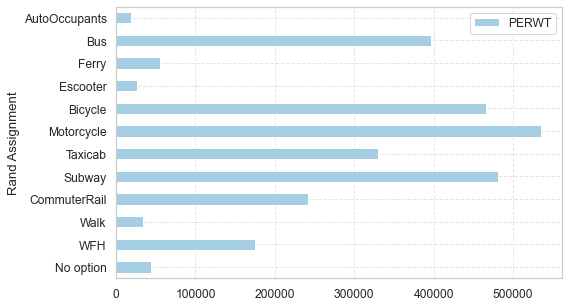

In [17]:
commuter_df = pd.read_csv("./samples/assignment_00_random.csv",index_col=0)
mode = commuter_df.groupby(by=["Rand Assignment"]).agg({"PERWT":"sum"}).reset_index()
order = CategoricalDtype(['AutoOccupants','Bus','Ferry','Escooter', 'Bicycle','Motorcycle','Taxicab','Subway','CommuterRail','Walk','WFH','No option'],ordered=True)
mode['Rand Assignment'] = mode['Rand Assignment'].astype(order)
mode.sort_values('Rand Assignment',inplace=True)
mode

fig,(ax1) = plt.subplots(1,1,figsize=(8,5),sharey=True)
plt.grid(ls='--',alpha=0.5)
mode.plot.barh(x='Rand Assignment', y='PERWT', ax=ax1)
plt.gca().invert_yaxis()

### 2. Energy Profile

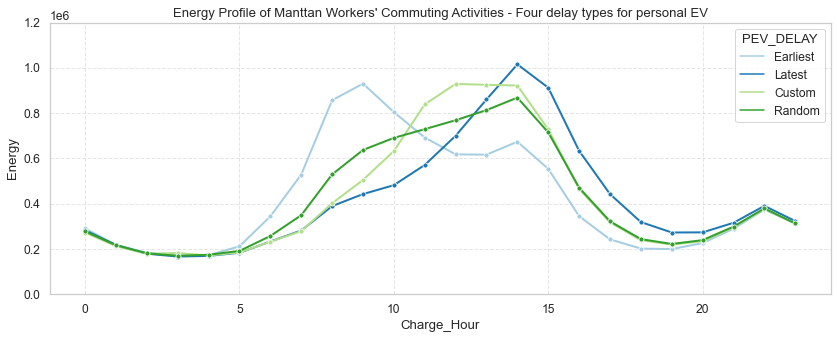

In [18]:
four_PEV_DELAY = df_agg.groupby(by=["Charge_Hour","PEV_DELAY"]).agg({"Energy":"sum"}).reset_index()
four_PEV_DELAY
fig,(ax1)=plt.subplots(1,1,figsize=(14,5),sharey=True)
plt.grid(ls='--',alpha=0.5)
sns.lineplot(data=four_PEV_DELAY,x='Charge_Hour',y='Energy',hue='PEV_DELAY',linewidth=2,marker='o',markersize=5)
ax1.set_ylim(0, 1.2e6)
ax1.set_title("Energy Profile of Manttan Workers' Commuting Activities - Four delay types for personal EV")
plt.show()

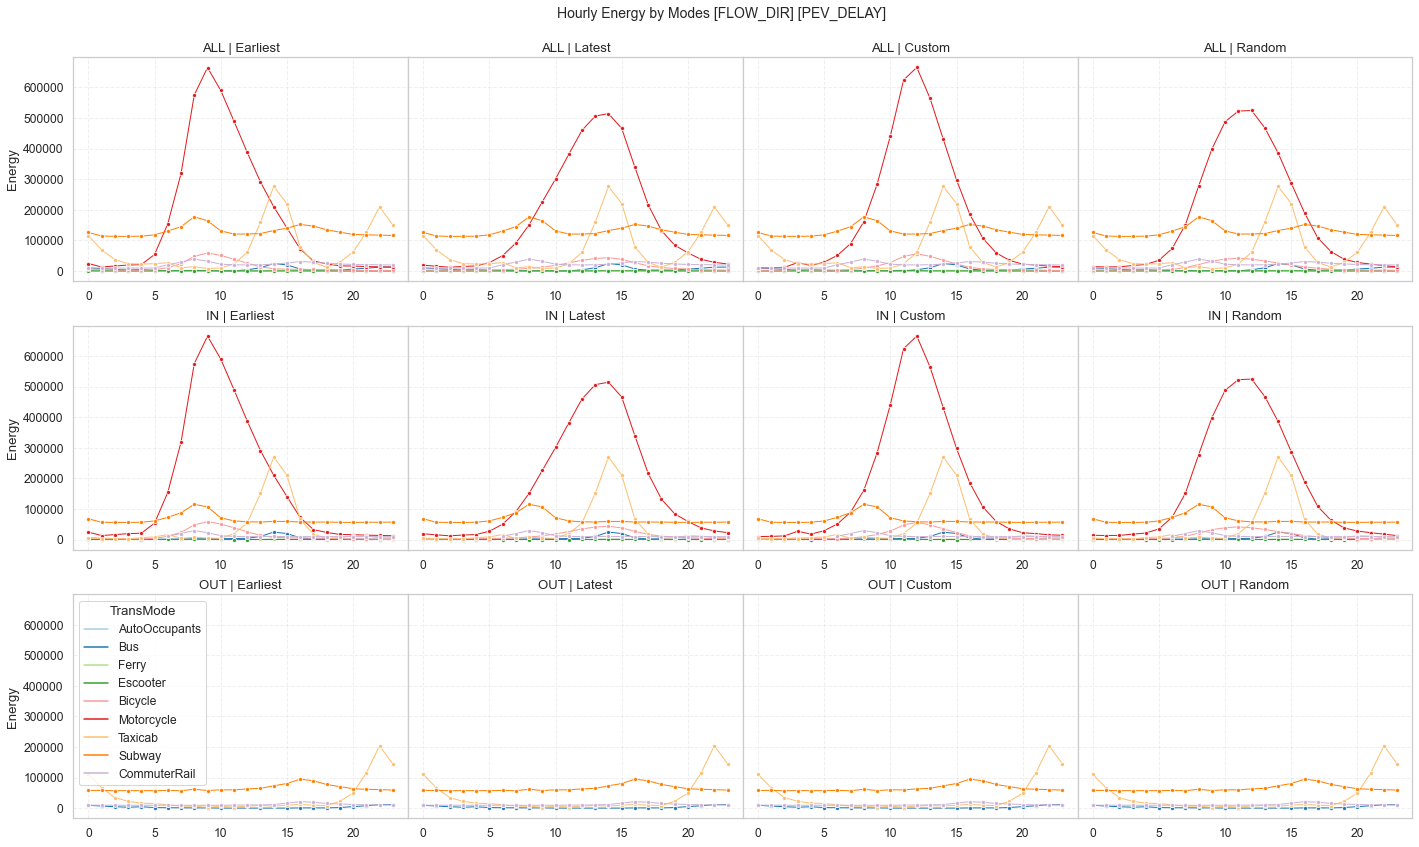

In [19]:
all_dir = df_agg.groupby(by=["Charge_Hour","TransMode","PEV_DELAY"]).agg({"Energy":"sum"}).reset_index()
all_dir['FLOW_DIR'] = 'ALL'
df_agg = pd.concat([df_agg, all_dir]).reset_index(drop=True)

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24,14),sharey=True)
plt.suptitle('Hourly Energy by Modes [FLOW_DIR] [PEV_DELAY]',x=0.5,y=0.93,fontsize=14)
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0,hspace=0.2)
dir_list = ['ALL','IN','OUT']
delay_list = ['Earliest','Latest','Custom','Random']
for i in range(3):
    for j in range(4):
        ax[i,j].grid(ls='--',alpha=0.3)
        sns.lineplot(data=df_agg[(df_agg['FLOW_DIR']==dir_list[i])&(df_agg['PEV_DELAY']==delay_list[j])],x='Charge_Hour',y='Energy',hue='TransMode',
                     linewidth=1,marker='o',markersize=4,ax=ax[i,j])
        if i != 2 or j!= 0:
            ax[i,j].legend([],[], frameon=False)
        ax[i,j].set_title(dir_list[i]+' | '+delay_list[j])
        ax[i,j].set(xlabel=None)

### 3. Traffic Flow

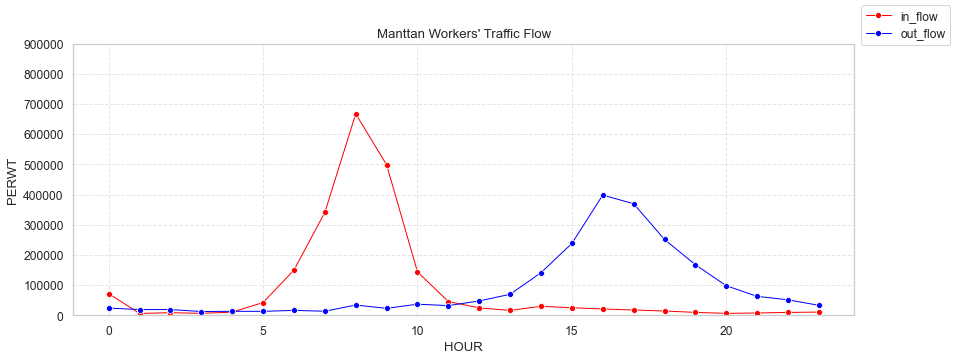

In [20]:
in_ = in_flow.groupby(by=["HOUR"]).agg({"PERWT":"sum"}).reset_index()
out_ = out_flow.groupby(by=["HOUR"]).agg({"PERWT":"sum"}).reset_index()
fig,(ax1)=plt.subplots(1,1,figsize=(14,5),sharey=True)
plt.grid(ls='--',alpha=0.5)
sns.lineplot(data=in_,x='HOUR',y='PERWT',marker='o',color='red',linewidth=1)
sns.lineplot(data=out_,x='HOUR',y='PERWT',marker='o',color='b',linewidth=1)
fig.legend(labels=['in_flow','out_flow'])
ax1.set_ylim(0, 9e5)
ax1.set_title("Manttan Workers' Traffic Flow")
plt.show()